# Цели
* проанализировать пассажирский поток на разных ветках метро
* подготовить данные к анализу
* изучить полученные данные
* выявить самые загруженные станции
* выявить наименее загруженные станции
* выявить самые загруженные ветки
* построить карту со всеми станциями метро и нанести на нее пассажиропток
* построить карту с таймлайном, чтобы посмотреть как меняется пассажиропток со временем
* сделать выводы

# Подготовка данных

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from collections import Counter
import geopandas as gpd
from geopandas.tools import geocode
import folium
from folium import plugins
from folium.plugins import HeatMap, HeatMapWithTime
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns

Получаем данные из статьи википедии о станция метро, так как там есть координаты станций

In [2]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations'
wiki_page = requests.get(wiki_url).text
wiki_doc = BeautifulSoup(wiki_page, 'html.parser')

# get the table containing the postal codes
stations_table = wiki_doc.find('table', {'class': 'wikitable sortable'})

## Список всех станций с координатами

In [3]:
indices = [0, 1, 6]

stations_df = pd.DataFrame(columns=['Line', 'Russian name', 'Coordinates'])

for tr in stations_table.find_all('tr')[1:]:
    line = re.search('#(.+?)\s', tr.find('a')['title']).group(1)
    cells = tr.find_all('td')
    # ignore cells that don't have coordinates
    if cells[6].text.strip() != '':
        stations_df = pd.concat([stations_df, pd.DataFrame.from_records([{
            'Line': line,
            'Russian name': cells[1].text.strip(),
            'Coordinates': cells[6].find('span', {'class': 'geo'}).text.strip().replace('; ', ',')
        }])], ignore_index=True)

stations_df

Line            Russian name          Coordinates
0      1   Бульвар Рокоссовского      55.8148,37.7342
1      1            Черкизовская      55.8038,37.7448
2      1  Преображенская площадь      55.7963,37.7151
3      1              Сокольники      55.7888,37.6802
4      1          Красносельская      55.7801,37.6673
..   ...                     ...                  ...
280   15           Юго-Восточная  55.704970,37.819010
281   15                  Косино      55.7033,37.8511
282   15     Улица Дмитриевского      55.7100,37.8792
283   15            Лухмановская      55.7085,37.9004
284   15              Некрасовка      55.7036,37.9264

[285 rows x 3 columns]

Тут есть координаты и то, в каком порядке они идут. Нам это в будущем понадобится

In [4]:
stations_df = stations_df.reset_index()


## Данные о пассажиропотоке 

In [5]:
transport_data = pd.read_csv(
    '/Volumes/Element_SE/data-115426-2022-10-21.csv', encoding='cp1251', sep=';', header=1)
transport_data.head(10)

Станция метрополитена                      Линия   Год    Квартал  \
0                Митино  Арбатско-Покровская линия  2021  I квартал   
1         Волоколамская  Арбатско-Покровская линия  2021  I квартал   
2              Строгино  Арбатско-Покровская линия  2021  I квартал   
3            Крылатское  Арбатско-Покровская линия  2021  I квартал   
4     Площадь Революции  Арбатско-Покровская линия  2021  I квартал   
5            Бауманская  Арбатско-Покровская линия  2021  I квартал   
6          Первомайская  Арбатско-Покровская линия  2021  I квартал   
7           Беломорская       Замоскворецкая линия  2021  I квартал   
8         Речной вокзал       Замоскворецкая линия  2021  I квартал   
9        Водный стадион       Замоскворецкая линия  2021  I квартал   

   Входы пассажиров  Выходы пассажиров   global_id  NameOfStation_en  Line_en  \
0           1913498            1829031  1138975996               NaN      NaN   
1           1236714            1222309  1138975997               NaN      NaN   
2           1938816            1903731  1138975999               NaN      NaN   
3           1849616            1818208  1138976000               NaN      NaN   
4           2324687            2319343  1138976008               NaN      NaN   
5           3757697            3919091  1138976010               NaN      NaN   
6           2554914            2542396  1138976015               NaN      NaN   
7           2093304            2007519  1138976018               NaN      NaN   
8           1976604            1932752  1138976019               NaN      NaN   
9           2798329            2787327  1138976020               NaN      NaN   

   Year_en  Quarter_en  IncomingPassengers_en  OutgoingPassengers_en  \
0      NaN         NaN                    NaN                    NaN   
1      NaN         NaN                    NaN                    NaN   
2      NaN         NaN                    NaN                    NaN   
3      NaN         NaN                    NaN                    NaN   
4      NaN         NaN                    NaN                    NaN   
5      NaN         NaN                    NaN                    NaN   
6      NaN         NaN                    NaN                    NaN   
7      NaN         NaN                    NaN                    NaN   
8      NaN         NaN                    NaN                    NaN   
9      NaN         NaN                    NaN                    NaN   

   Unnamed: 13  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
5          NaN  
6          NaN  
7          NaN  
8          NaN  
9          NaN

По всей видимости данные должны были быть представлены на английском и русском языке, но от этого отказались. Удаляем лишние столбцы

In [6]:
transport_data = transport_data.drop(columns=['global_id', 'NameOfStation_en', 'Line_en',
                                     'Year_en', 'Quarter_en', 'IncomingPassengers_en', 'OutgoingPassengers_en', 'Unnamed: 13'])

Задаем англоязычные названия, так как они короче

In [7]:
transport_data = transport_data.rename(columns={"Станция метрополитена": "station", "Линия": "line",
                                       "Год": "year", 'Квартал': 'quarter', 'Входы пассажиров': 'pass_entr', 'Выходы пассажиров': 'pass_exit'})
transport_data

station                           line  year      quarter  \
0                   Митино      Арбатско-Покровская линия  2021    I квартал   
1            Волоколамская      Арбатско-Покровская линия  2021    I квартал   
2                 Строгино      Арбатско-Покровская линия  2021    I квартал   
3               Крылатское      Арбатско-Покровская линия  2021    I квартал   
4        Площадь Революции      Арбатско-Покровская линия  2021    I квартал   
...                    ...                            ...   ...          ...   
1682          Авиамоторная              Калининская линия  2022  III квартал   
1683              Киевская                Кольцевая линия  2022  III квартал   
1684      Ботанический сад  Московское центральное кольцо  2022  III квартал   
1685           Кутузовская  Московское центральное кольцо  2022  III квартал   
1686  Проспект Вернадского           Сокольническая линия  2022  III квартал   

      pass_entr  pass_exit  
0       1913498    1829031  
1       1236714    1222309  
2       1938816    1903731  
3       1849616    1818208  
4       2324687    2319343  
...         ...        ...  
1682    3400258    3570615  
1683    3152625    3070193  
1684    1002370    1225726  
1685    1543093    1721750  
1686    2149699    2173954  

[1687 rows x 6 columns]

На всякий случай убедимся что в таблице всё в порядке и нет дубликатов и пропущенных значений.

In [8]:
transport_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687 entries, 0 to 1686
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   station    1687 non-null   object
 1   line       1687 non-null   object
 2   year       1687 non-null   int64 
 3   quarter    1687 non-null   object
 4   pass_entr  1687 non-null   int64 
 5   pass_exit  1687 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 79.2+ KB


In [9]:
transport_data.duplicated().sum()

0

In [10]:
transport_data.isna().sum()

station      0
line         0
year         0
quarter      0
pass_entr    0
pass_exit    0
dtype: int64

Действительно, в таблице всё в порядке

In [11]:
def line_number(row):  # функция для того, чтобы задать номер станции.

    if row['line'] == 'Арбатско-Покровская линия':
        return '3'
    elif row['line'] == 'Замоскворецкая линия':
        return '2'
    elif row['line'] == 'Серпуховско-Тимирязевская линия':
        return '9'
    elif row['line'] == 'Таганско-Краснопресненская линия':
        return '7'
    elif row['line'] == 'Калужско-Рижская линия':
        return '6'
    elif row['line'] == 'Калининская линия':
        return '8'
    elif row['line'] == 'Кольцевая линия':
        return '5'
    elif row['line'] == 'Большая кольцевая линия':
        return '11'
    elif row['line'] == 'Московское центральное кольцо':
        return '14'
    elif row['line'] == 'Некрасовская линия':
        return '15'
    elif row['line'] == 'Сокольническая линия':
        return '1'
    elif row['line'] == 'Солнцевская линия':
        return '8A'
    elif row['line'] == 'Филёвская линия':
        return '4'
    elif row['line'] == 'Люблинско-Дмитровская линия':
        return '10'


def line_color(row):  # функция чтобы задать цвет станции. Он понадобится для визуализации

    if row['line'] == 'Арбатско-Покровская линия':
        return 'blue'
    elif row['line'] == 'Замоскворецкая линия':
        return 'green'
    elif row['line'] == 'Серпуховско-Тимирязевская линия':
        return 'grey'
    elif row['line'] == 'Таганско-Краснопресненская линия':
        return 'purple'
    elif row['line'] == 'Калужско-Рижская линия':
        return 'orange'
    elif row['line'] == 'Калининская линия':
        return 'yellow'
    elif row['line'] == 'Кольцевая линия':
        return 'brown'
    elif row['line'] == 'Большая кольцевая линия':
        return 'cyan'
    elif row['line'] == 'Московское центральное кольцо':
        return 'tomato'
    elif row['line'] == 'Некрасовская линия':
        return 'pink'
    elif row['line'] == 'Сокольническая линия':
        return 'red'
    elif row['line'] == 'Солнцевская линия':
        return 'yellow'
    elif row['line'] == 'Филёвская линия':
        return 'skyblue'
    elif row['line'] == 'Люблинско-Дмитровская линия':
        return 'yellowgreen'


def get_coordinates(number):  # Функция для подстановки координат. нужна для визуализации

    coordinates = transport_data.query("line_number==@number")

    coordinates = coordinates.sort_values('index')
    coordinates = coordinates[['latitude', 'longitude']]
    if number == '5' or number == '14':
        coordinates = pd.concat([coordinates, coordinates[0:1]])
    else:
        coordinates = coordinates
    return coordinates


def get_colors(number):  # Функция для подстановки цвета. нужна для визуализации

    query_line = transport_data.query("line_number==@number")
    color = query_line['line_color'].unique()

    return color


def data_convert(row):  # функция для превращения римских цифр в арабские в упрощенном виде
    if re.search('I', str(row['quarter'])) and not re.search('V', str(row['quarter'])):
        return str(row['year']) + 'Q'+str(Counter(row['quarter']).get('I'))
    if re.search('V', str(row['quarter'])):
        return str(row['year']) + 'Q4'

Применяем заданные функции, чтобы соединить таблицу с координатами и заодно добавить в нее столбцы 

In [12]:
transport_data['line_number'] = transport_data.apply(line_number, axis=1)
transport_data['line_color'] = transport_data.apply(line_color, axis=1)
transport_data['date'] = transport_data.apply(data_convert, axis=1)

transport_data

station                           line  year      quarter  \
0                   Митино      Арбатско-Покровская линия  2021    I квартал   
1            Волоколамская      Арбатско-Покровская линия  2021    I квартал   
2                 Строгино      Арбатско-Покровская линия  2021    I квартал   
3               Крылатское      Арбатско-Покровская линия  2021    I квартал   
4        Площадь Революции      Арбатско-Покровская линия  2021    I квартал   
...                    ...                            ...   ...          ...   
1682          Авиамоторная              Калининская линия  2022  III квартал   
1683              Киевская                Кольцевая линия  2022  III квартал   
1684      Ботанический сад  Московское центральное кольцо  2022  III квартал   
1685           Кутузовская  Московское центральное кольцо  2022  III квартал   
1686  Проспект Вернадского           Сокольническая линия  2022  III квартал   

      pass_entr  pass_exit line_number line_color    date  
0       1913498    1829031           3       blue  2021Q1  
1       1236714    1222309           3       blue  2021Q1  
2       1938816    1903731           3       blue  2021Q1  
3       1849616    1818208           3       blue  2021Q1  
4       2324687    2319343           3       blue  2021Q1  
...         ...        ...         ...        ...     ...  
1682    3400258    3570615           8     yellow  2022Q3  
1683    3152625    3070193           5      brown  2022Q3  
1684    1002370    1225726          14     tomato  2022Q3  
1685    1543093    1721750          14     tomato  2022Q3  
1686    2149699    2173954           1        red  2022Q3  

[1687 rows x 9 columns]

Соединяем таблицы на основе названия станции и номер линии. нам это нужно, чтобы координаты были точны

In [13]:
transport_data = transport_data.merge(stations_df, left_on=['station', 'line_number'], right_on=[
    'Russian name', 'Line'])

Удаляем лишние столбцы и смотрим таблицу 

In [14]:
transport_data = transport_data.drop(columns=['Line', 'Russian name'])
transport_data

station                       line  year      quarter  \
0                      Митино  Арбатско-Покровская линия  2021    I квартал   
1                      Митино  Арбатско-Покровская линия  2021   II квартал   
2                      Митино  Арбатско-Покровская линия  2021  III квартал   
3                      Митино  Арбатско-Покровская линия  2021   IV квартал   
4                      Митино  Арбатско-Покровская линия  2022    I квартал   
...                       ...                        ...   ...          ...   
1537              Театральная       Замоскворецкая линия  2022    I квартал   
1538              Театральная       Замоскворецкая линия  2022   II квартал   
1539  Библиотека имени Ленина       Сокольническая линия  2021   IV квартал   
1540  Библиотека имени Ленина       Сокольническая линия  2022    I квартал   
1541  Библиотека имени Ленина       Сокольническая линия  2022   II квартал   

      pass_entr  pass_exit line_number line_color    date  index  \
0       1913498    1829031           3       blue  2021Q1     51   
1       2119285    1991048           3       blue  2021Q2     51   
2       2077107    1922906           3       blue  2021Q3     51   
3       2217044    2090460           3       blue  2021Q4     51   
4       2005840    1920776           3       blue  2022Q1     51   
...         ...        ...         ...        ...     ...    ...   
1537          0          0           2      green  2022Q1     37   
1538          0          0           2      green  2022Q2     37   
1539          0          0           1        red  2021Q4     10   
1540          0          0           1        red  2022Q1     10   
1541          0          0           1        red  2022Q2     10   

          Coordinates  
0     55.8457,37.3622  
1     55.8457,37.3622  
2     55.8457,37.3622  
3     55.8457,37.3622  
4     55.8457,37.3622  
...               ...  
1537  55.7578,37.6190  
1538  55.7578,37.6190  
1539  55.7512,37.6100  
1540  55.7512,37.6100  
1541  55.7512,37.6100  

[1542 rows x 11 columns]

Есть подозрение что в таблице есть пропущенные данные, но они заполнены нулями

In [15]:
transport_data.query('pass_entr==0')

station                              line  year  \
126            Новослободская                   Кольцевая линия  2021   
127            Новослободская                   Кольцевая линия  2021   
128            Новослободская                   Кольцевая линия  2021   
129            Новослободская                   Кольцевая линия  2021   
156                   Рижская            Калужско-Рижская линия  2021   
157                   Рижская            Калужско-Рижская линия  2021   
158                   Рижская            Калужско-Рижская линия  2021   
159                   Рижская            Калужско-Рижская линия  2021   
160                   Рижская            Калужско-Рижская линия  2022   
852        Народное Ополчение           Большая кольцевая линия  2021   
1312               Смоленская         Арбатско-Покровская линия  2021   
1313               Смоленская         Арбатско-Покровская линия  2021   
1484    Петровско-Разумовская   Серпуховско-Тимирязевская линия  2021   
1485    Петровско-Разумовская   Серпуховско-Тимирязевская линия  2021   
1486    Петровско-Разумовская   Серпуховско-Тимирязевская линия  2022   
1487    Петровско-Разумовская   Серпуховско-Тимирязевская линия  2022   
1488            Третьяковская            Калужско-Рижская линия  2021   
1489            Третьяковская            Калужско-Рижская линия  2021   
1490            Третьяковская            Калужско-Рижская линия  2022   
1491            Третьяковская            Калужско-Рижская линия  2022   
1492              Китай-город  Таганско-Краснопресненская линия  2021   
1493              Китай-город  Таганско-Краснопресненская линия  2021   
1494              Китай-город  Таганско-Краснопресненская линия  2022   
1495              Китай-город  Таганско-Краснопресненская линия  2022   
1496                 Киевская                   Филёвская линия  2021   
1497                 Киевская                   Филёвская линия  2021   
1498                 Киевская                   Филёвская линия  2022   
1499                 Киевская                   Филёвская линия  2022   
1533                 Тверская              Замоскворецкая линия  2021   
1534                 Тверская              Замоскворецкая линия  2022   
1535                 Тверская              Замоскворецкая линия  2022   
1536              Театральная              Замоскворецкая линия  2021   
1537              Театральная              Замоскворецкая линия  2022   
1538              Театральная              Замоскворецкая линия  2022   
1539  Библиотека имени Ленина              Сокольническая линия  2021   
1540  Библиотека имени Ленина              Сокольническая линия  2022   
1541  Библиотека имени Ленина              Сокольническая линия  2022   

          quarter  pass_entr  pass_exit line_number line_color    date  index  \
126     I квартал          0          0           5      brown  2021Q1     88   
127    II квартал          0          0           5      brown  2021Q2     88   
128   III квартал          0          0           5      brown  2021Q3     88   
129    IV квартал          0          0           5      brown  2021Q4     88   
156     I квартал          0          0           6     orange  2021Q1    103   
157    II квартал          0          0           6     orange  2021Q2    103   
158   III квартал          0          0           6     orange  2021Q3    103   
159    IV квартал          0          0           6     orange  2021Q4    103   
160     I квартал          0          0           6     orange  2022Q1    103   
852     I квартал          0          0          11       cyan  2021Q1    223   
1312    I квартал          0          0           3       blue  2021Q1     61   
1313   II квартал          0          0           3       blue  2021Q2     61   
1484  III квартал          0          0           9       grey  2021Q3    168   
1485   IV квартал          0          0           9       grey  2021Q4    168   
1486    I квартал          0    

Так и есть. Посмотрим откуда они взялись?

In [16]:
transport_data.query('station=="Китай-город"')

station                              line  year      quarter  \
1103  Китай-город            Калужско-Рижская линия  2021    I квартал   
1104  Китай-город            Калужско-Рижская линия  2021   II квартал   
1105  Китай-город            Калужско-Рижская линия  2021  III квартал   
1106  Китай-город            Калужско-Рижская линия  2021   IV квартал   
1107  Китай-город            Калужско-Рижская линия  2022    I квартал   
1108  Китай-город            Калужско-Рижская линия  2022   II квартал   
1109  Китай-город            Калужско-Рижская линия  2022  III квартал   
1492  Китай-город  Таганско-Краснопресненская линия  2021  III квартал   
1493  Китай-город  Таганско-Краснопресненская линия  2021   IV квартал   
1494  Китай-город  Таганско-Краснопресненская линия  2022    I квартал   
1495  Китай-город  Таганско-Краснопресненская линия  2022   II квартал   

      pass_entr  pass_exit line_number line_color    date  index  \
1103    3917616    4045824           6     orange  2021Q1    107   
1104    4599802    4721453           6     orange  2021Q2    107   
1105    4450614    4586292           6     orange  2021Q3    107   
1106    4654371    4809350           6     orange  2021Q4    107   
1107    4385148    4516994           6     orange  2022Q1    107   
1108    5146888    5344406           6     orange  2022Q2    107   
1109    5124726    5314589           6     orange  2022Q3    107   
1492          0          0           7     purple  2021Q3    133   
1493          0          0           7     purple  2021Q4    133   
1494          0          0           7     purple  2022Q1    133   
1495          0          0           7     purple  2022Q2    133   

          Coordinates  
1103  55.7553,37.6333  
1104  55.7553,37.6333  
1105  55.7553,37.6333  
1106  55.7553,37.6333  
1107  55.7553,37.6333  
1108  55.7553,37.6333  
1109  55.7553,37.6333  
1492  55.7553,37.6333  
1493  55.7553,37.6333  
1494  55.7553,37.6333  
1495  55.7553,37.6333

Так как в таблице обнаружены нулевые значения, а заполнить их не имеет никакой возможности, то просто удалим их. По всей видимости они образовались на станциях, где есть общий выход для нескольких станций, поэтому там нет возможносии считать отдельные входы и выходы. Нужно учитывать это при подсчете самых непопулярных станций

## Полнота данных

Убедимся что данные полны.

In [17]:
len(transport_data.query('date=="2021Q1"'))

242

In [18]:
len(transport_data.query('date=="2021Q2"'))

243

In [19]:
len(transport_data.query('date=="2022Q1"'))

261

In [20]:
len(transport_data.query('date=="2022Q2"'))

260

In [21]:
len(transport_data.query('date=="2022Q3"'))

30

Как видим, количество меняется незначительно. скорее всего, на него влияет количество станций в тот или иной момент. А представленные данные за 3 квартал 2022 года не полны, поэтому избавимся от них

In [22]:
transport_data = transport_data.query('date!="2022Q3"')


# Изучение данных и добавление новых данных

Добавим новый столбец с суммой пассажиров, которые проходят через станцию, сложив входы и выходы. Это лучше всего показывает загруженность станции в течение дня

In [23]:
pd.options.mode.chained_assignment = None 
transport_data['total_pass'] = transport_data['pass_entr'] + \
    transport_data['pass_exit']
transport_data

station                       line  year      quarter  \
0                      Митино  Арбатско-Покровская линия  2021    I квартал   
1                      Митино  Арбатско-Покровская линия  2021   II квартал   
2                      Митино  Арбатско-Покровская линия  2021  III квартал   
3                      Митино  Арбатско-Покровская линия  2021   IV квартал   
4                      Митино  Арбатско-Покровская линия  2022    I квартал   
...                       ...                        ...   ...          ...   
1537              Театральная       Замоскворецкая линия  2022    I квартал   
1538              Театральная       Замоскворецкая линия  2022   II квартал   
1539  Библиотека имени Ленина       Сокольническая линия  2021   IV квартал   
1540  Библиотека имени Ленина       Сокольническая линия  2022    I квартал   
1541  Библиотека имени Ленина       Сокольническая линия  2022   II квартал   

      pass_entr  pass_exit line_number line_color    date  index  \
0       1913498    1829031           3       blue  2021Q1     51   
1       2119285    1991048           3       blue  2021Q2     51   
2       2077107    1922906           3       blue  2021Q3     51   
3       2217044    2090460           3       blue  2021Q4     51   
4       2005840    1920776           3       blue  2022Q1     51   
...         ...        ...         ...        ...     ...    ...   
1537          0          0           2      green  2022Q1     37   
1538          0          0           2      green  2022Q2     37   
1539          0          0           1        red  2021Q4     10   
1540          0          0           1        red  2022Q1     10   
1541          0          0           1        red  2022Q2     10   

          Coordinates  total_pass  
0     55.8457,37.3622     3742529  
1     55.8457,37.3622     4110333  
2     55.8457,37.3622     4000013  
3     55.8457,37.3622     4307504  
4     55.8457,37.3622     3926616  
...               ...         ...  
1537  55.7578,37.6190           0  
1538  55.7578,37.6190           0  
1539  55.7512,37.6100           0  
1540  55.7512,37.6100           0  
1541  55.7512,37.6100           0  

[1512 rows x 12 columns]

Из строки с координатами получим два столбца с широтой и долготой, для этого разделим их по запятой.

In [24]:
transport_data[["latitude", "longitude"]] = pd.DataFrame(transport_data['Coordinates']
                                                         .str.split(",", expand=True), index=transport_data.index)

Сразу зададим новым столбцам необходимый формат. Заодно добавим новому столбцу с датой тоже формат даты

In [25]:
transport_data = transport_data.astype(
    {'latitude': 'float', 'longitude': 'float', })
transport_data['date'] = pd.PeriodIndex(transport_data['date'], freq='Q')


Снова удаляем теперь не нужные столбцы с годом, кварталом и коррдинатами

In [26]:
transport_data = transport_data.drop(
    columns=['year', 'quarter', 'Coordinates'])
transport_data

station                       line  pass_entr  \
0                      Митино  Арбатско-Покровская линия    1913498   
1                      Митино  Арбатско-Покровская линия    2119285   
2                      Митино  Арбатско-Покровская линия    2077107   
3                      Митино  Арбатско-Покровская линия    2217044   
4                      Митино  Арбатско-Покровская линия    2005840   
...                       ...                        ...        ...   
1537              Театральная       Замоскворецкая линия          0   
1538              Театральная       Замоскворецкая линия          0   
1539  Библиотека имени Ленина       Сокольническая линия          0   
1540  Библиотека имени Ленина       Сокольническая линия          0   
1541  Библиотека имени Ленина       Сокольническая линия          0   

      pass_exit line_number line_color    date  index  total_pass  latitude  \
0       1829031           3       blue  2021Q1     51     3742529   55.8457   
1       1991048           3       blue  2021Q2     51     4110333   55.8457   
2       1922906           3       blue  2021Q3     51     4000013   55.8457   
3       2090460           3       blue  2021Q4     51     4307504   55.8457   
4       1920776           3       blue  2022Q1     51     3926616   55.8457   
...         ...         ...        ...     ...    ...         ...       ...   
1537          0           2      green  2022Q1     37           0   55.7578   
1538          0           2      green  2022Q2     37           0   55.7578   
1539          0           1        red  2021Q4     10           0   55.7512   
1540          0           1        red  2022Q1     10           0   55.7512   
1541          0           1        red  2022Q2     10           0   55.7512   

      longitude  
0       37.3622  
1       37.3622  
2       37.3622  
3       37.3622  
4       37.3622  
...         ...  
1537    37.6190  
1538    37.6190  
1539    37.6100  
1540    37.6100  
1541    37.6100  

[1512 rows x 11 columns]

Проверим что все типы применились и не нужно их корректировать

In [27]:
transport_data.dtypes

station               object
line                  object
pass_entr              int64
pass_exit              int64
line_number           object
line_color            object
date           period[Q-DEC]
index                  int64
total_pass             int64
latitude             float64
longitude            float64
dtype: object

## Самые загруженные станции таблица

In [28]:
max_station = pd.pivot_table(transport_data,  values=['total_pass', 'pass_entr', 'pass_exit'], index=[
    'station', 'line'], aggfunc='sum').reset_index(level=1).sort_values('total_pass', ascending=False).head(10)
max_station

line  pass_entr  pass_exit  \
station                                                                      
Комсомольская                        Кольцевая линия   44783585   37543561   
Щёлковская                 Арбатско-Покровская линия   36890798   35154110   
Новогиреево                        Калининская линия   33175747   32212722   
ВДНХ                          Калужско-Рижская линия   32206236   30940162   
Выхино              Таганско-Краснопресненская линия   31113325   30155808   
Домодедовская                   Замоскворецкая линия   30526705   28360566   
Кузьминки           Таганско-Краснопресненская линия   28653716   28574249   
Новокосино                         Калининская линия   28928415   27935018   
Царицыно                        Замоскворецкая линия   28845545   28012504   
Славянский бульвар         Арбатско-Покровская линия   28394858   27935710   

                    total_pass  
station                         
Комсомольская         82327146  
Щёлковская            72044908  
Новогиреево           65388469  
ВДНХ                  63146398  
Выхино                61269133  
Домодедовская         58887271  
Кузьминки             57227965  
Новокосино            56863433  
Царицыно              56858049  
Славянский бульвар    56330568

Большая часть наиболее загруженных станций находятся на окраине и являются одними из конечных станций. Исключения ВДНХ, Комсомольская и Славянский бульвар. Комсомольская находится возле трех вокзалов, что дает на нее значительную нагрузку. Причем, на ней гораздо чаще входят, чем выходят. На других станциях не такая большая разница. Славянский бульвар находится возле крупного узла электричек. А ВДНХ скорее всего популярна из-за того, что большой поток людей приезжают гулять на ВДНХ.

## Наименее загруженные станции таблица

In [29]:
min_station = pd.pivot_table(transport_data,  values=['total_pass', 'pass_entr', 'pass_exit'], index=[
    'station', 'line'], aggfunc='sum').sort_values('total_pass', ascending=False).tail(17).reset_index(level=1)
min_station

line  pass_entr  \
station                                                                
Аминьевская                       Большая кольцевая линия    1743237   
Парк Победы                             Солнцевская линия    1670179   
Давыдково                         Большая кольцевая линия    1525651   
Мичуринский проспект              Большая кольцевая линия    1413623   
Воронцовская                      Большая кольцевая линия    1248960   
Проспект Вернадского              Большая кольцевая линия     843363   
Рижская                            Калужско-Рижская линия     560639   
Белокаменная                Московское центральное кольцо     538767   
Терехово                          Большая кольцевая линия     375973   
Мнёвники                          Большая кольцевая линия     372842   
Библиотека имени Ленина              Сокольническая линия          0   
Петровско-Разумовская     Серпуховско-Тимирязевская линия          0   
Третьяковская                      Калужско-Рижская линия          0   
Театральная                          Замоскворецкая линия          0   
Тверская                             Замоскворецкая линия          0   
Китай-город              Таганско-Краснопресненская линия          0   
Киевская                                  Филёвская линия          0   

                         pass_exit  total_pass  
station                                         
Аминьевская                1706127     3449364  
Парк Победы                1738717     3408896  
Давыдково                  1523743     3049394  
Мичуринский проспект       1417419     2831042  
Воронцовская               1297425     2546385  
Проспект Вернадского        850958     1694321  
Рижская                     570695     1131334  
Белокаменная                560398     1099165  
Терехово                    402365      778338  
Мнёвники                    383030      755872  
Библиотека имени Ленина          0           0  
Петровско-Разумовская            0           0  
Третьяковская                    0           0  
Театральная                      0           0  
Тверская                         0           0  
Китай-город                      0           0  
Киевская                         0           0

Чтобы корректно посчитать количество наименее популярных станций, нам нужно отсеять те, данные для которых нам не предоставили. Но при этом, если просто сразу убрать все значения с нулем, то отсеятся станции, которые были закрыты какое-то время. Поэтому мы запрашиваем немного больше, а потом отсеиваем только те, у которых за все время 0

In [30]:
min_station = min_station.query('pass_entr!=0')
min_station

line  pass_entr  pass_exit  \
station                                                                     
Аминьевская                 Большая кольцевая линия    1743237    1706127   
Парк Победы                       Солнцевская линия    1670179    1738717   
Давыдково                   Большая кольцевая линия    1525651    1523743   
Мичуринский проспект        Большая кольцевая линия    1413623    1417419   
Воронцовская                Большая кольцевая линия    1248960    1297425   
Проспект Вернадского        Большая кольцевая линия     843363     850958   
Рижская                      Калужско-Рижская линия     560639     570695   
Белокаменная          Московское центральное кольцо     538767     560398   
Терехово                    Большая кольцевая линия     375973     402365   
Мнёвники                    Большая кольцевая линия     372842     383030   

                      total_pass  
station                           
Аминьевская              3449364  
Парк Победы              3408896  
Давыдково                3049394  
Мичуринский проспект     2831042  
Воронцовская             2546385  
Проспект Вернадского     1694321  
Рижская                  1131334  
Белокаменная             1099165  
Терехово                  778338  
Мнёвники                  755872

Здесь присутствуют в основном станции БКЛ. Но это не удивительно, ведь оно еще не целиком открыто. А её эффективность в виду длины именно в коротких поездках между двумя соседними линиями. 

In [31]:
# Оставляем в только те станции, которые попали в топ
data_station_top = transport_data.query('station in @max_station.index')
data_station_top = data_station_top.sort_values(
    ['date', 'total_pass'], ascending=[True, False])

In [32]:
# Аналогично поступаем и с наименее загруженными станциями.
data_station_botom = transport_data.query(
    'station in @min_station.index  & line in @min_station.line')
data_station_botom = data_station_botom.query('index!= 150')
data_station_botom = data_station_botom.sort_values(
    ['date', 'total_pass'], ascending=[True, False])

In [33]:
# Подготовим цвета для графика, чтобы учитывать цвет линии соответсвовал её цвету на карте
transport_data_grouped = transport_data.groupby(['line', 'date', 'line_color']).agg(
    пассажиропоток=('total_pass', 'sum')).reset_index('line_color')
my_colors = list(transport_data_grouped['line_color'].unique())
my_colors.insert(11, 'yellow')

## Пассажиропоток для всех линий по кварталам график

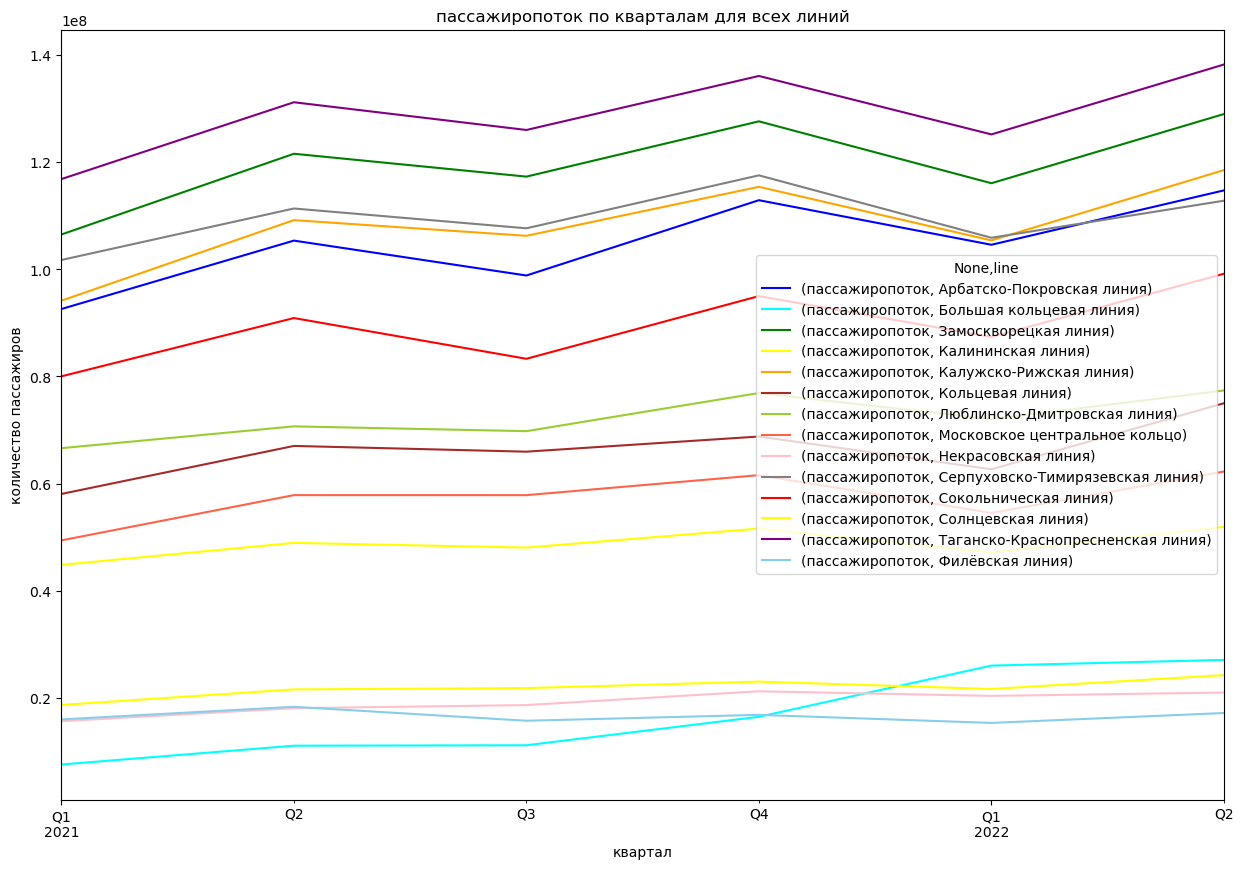

In [34]:
transport_data_grouped.unstack('line').plot(
    title='пассажиропоток по кварталам для всех линий',
    xlabel='квартал',
    ylabel='количество пассажиров',
    color=my_colors,
    figsize=(15, 10))
plt.show()

В первом квартале 2021 года и 2022 года пассажиропток низкий. Потом во втором квартале он начинает расти, а потом в третьем снижается. 
Это можно обьяснить с тем, что зимой на праздники многие уезжают (в первом квартале не только январские праздники, но и 23 февраля и 8 марта). Потом пассажиропоток начинает расти из-за того что во втором квартале не так много праздников. И падает к лету, когда многие уезжают в отпуска. Потом снова начинает расти к концу года. Причем, со временем именно к концу года он достигает максимума

In [35]:
stations = transport_data.groupby(['line', 'date', 'line_color']).agg(пассажиропоток=(
    'total_pass', 'sum')).sort_values(['date', 'пассажиропоток'], ascending=[True, False]).reset_index()

## Пассажиропоток для линий barplot

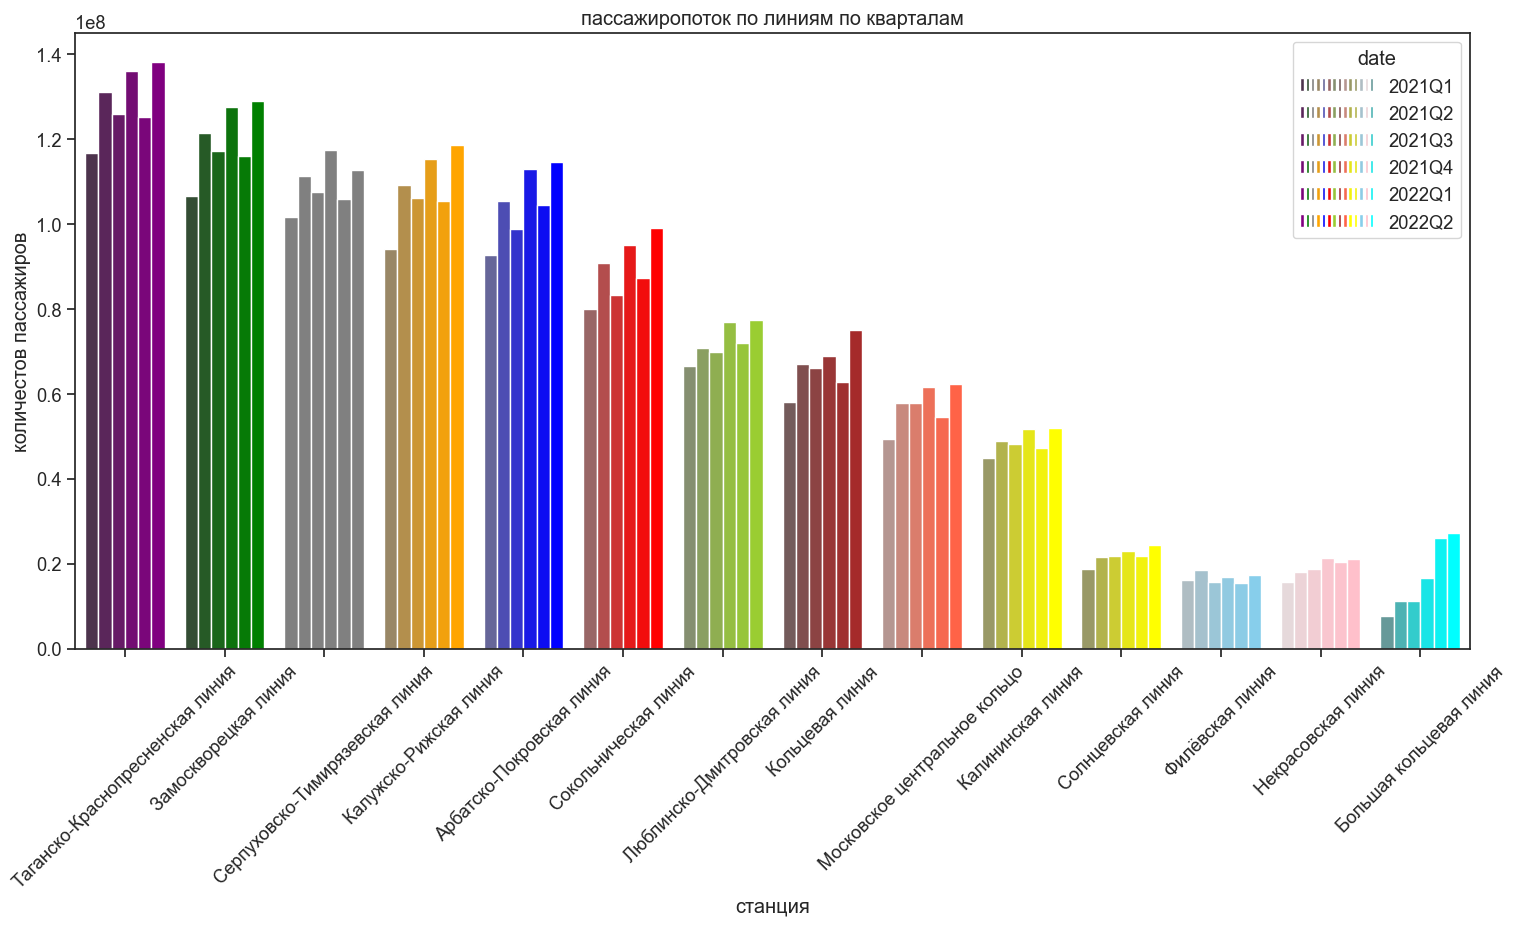

In [36]:
plt.figure(figsize=(18, 8))
sns.set(style='ticks', context='notebook', font_scale=1.2)
ax = sns.barplot(x="line", y="пассажиропоток", hue="date", data=stations,

                 )
for bar_group, desaturate_value in zip(ax.containers, [0.2, 0.4, 0.6, 0.8, 0.9, 1]):
    for bar, color in zip(bar_group, stations['line_color']):
        bar.set_facecolor(sns.desaturate(color, desaturate_value))

ax.set(title='пассажиропоток по линиям по кварталам',
       xlabel='станция', ylabel='количестов пассажиров')
ax.legend(handles=[tuple(bar_group) for bar_group in ax.containers],
          labels=[bar_group.get_label() for bar_group in ax.containers],
          title=ax.legend_.get_title().get_text(),
          handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)})


plt.xticks(rotation=45)
plt.show()

Пассажиропоток у линий не так сильно меняется в завимости от квартала и года. Рост есть только у БКЛ. Он связан прежде всего с вводом новых линий. У Солнцевской, Филевской и Некрасовской линии пото остается приблизительно постоянным, тогда как у других станций он меняется сильнее

## Наиболее загруженные станции Barplot

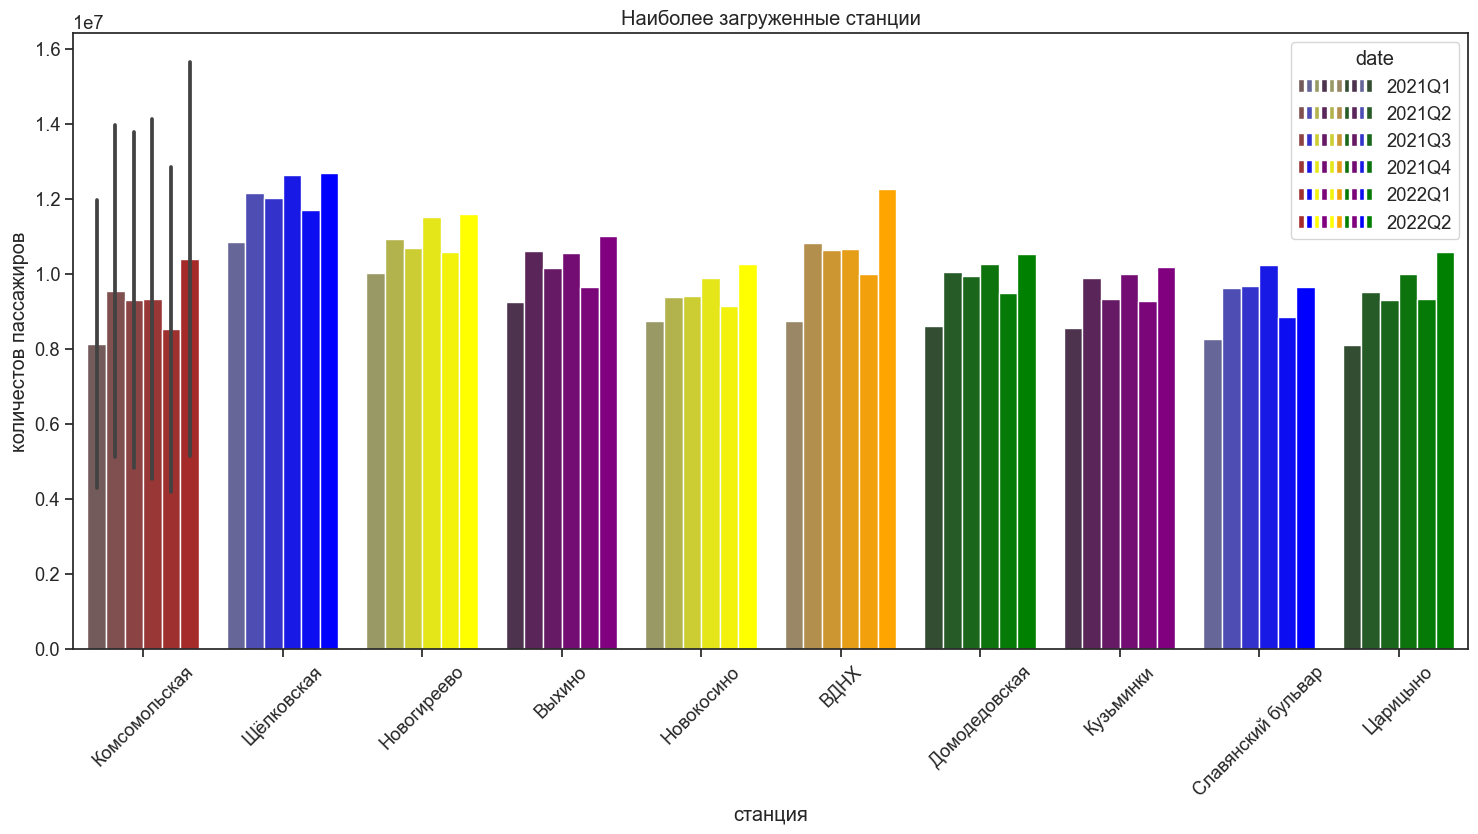

In [37]:
plt.figure(figsize=(18, 8))
ax = sns.barplot(x='station', y='total_pass', hue='date', data=data_station_top)
for bar_group, desaturate_value in zip(ax.containers, [0.2,0.4,0.6, 0.8,0.9,1]):
    for bar, color in zip(bar_group,data_station_top['line_color'] ):
        bar.set_facecolor(sns.desaturate(color, desaturate_value))
ax.set(title='Наиболее загруженные станции', xlabel='станция', ylabel= 'количестов пассажиров' )
ax.legend(handles=[tuple(bar_group) for bar_group in ax.containers],
          labels=[bar_group.get_label() for bar_group in ax.containers],
          title=ax.legend_.get_title().get_text(),
          handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)})


plt.xticks(rotation=45)
plt.show()

Пассажиропоток вырос значительно только на ВДНХ и Царицыно. Но в целом он остается приблизительно тем же 

## Наименее загруженные станции Barplot

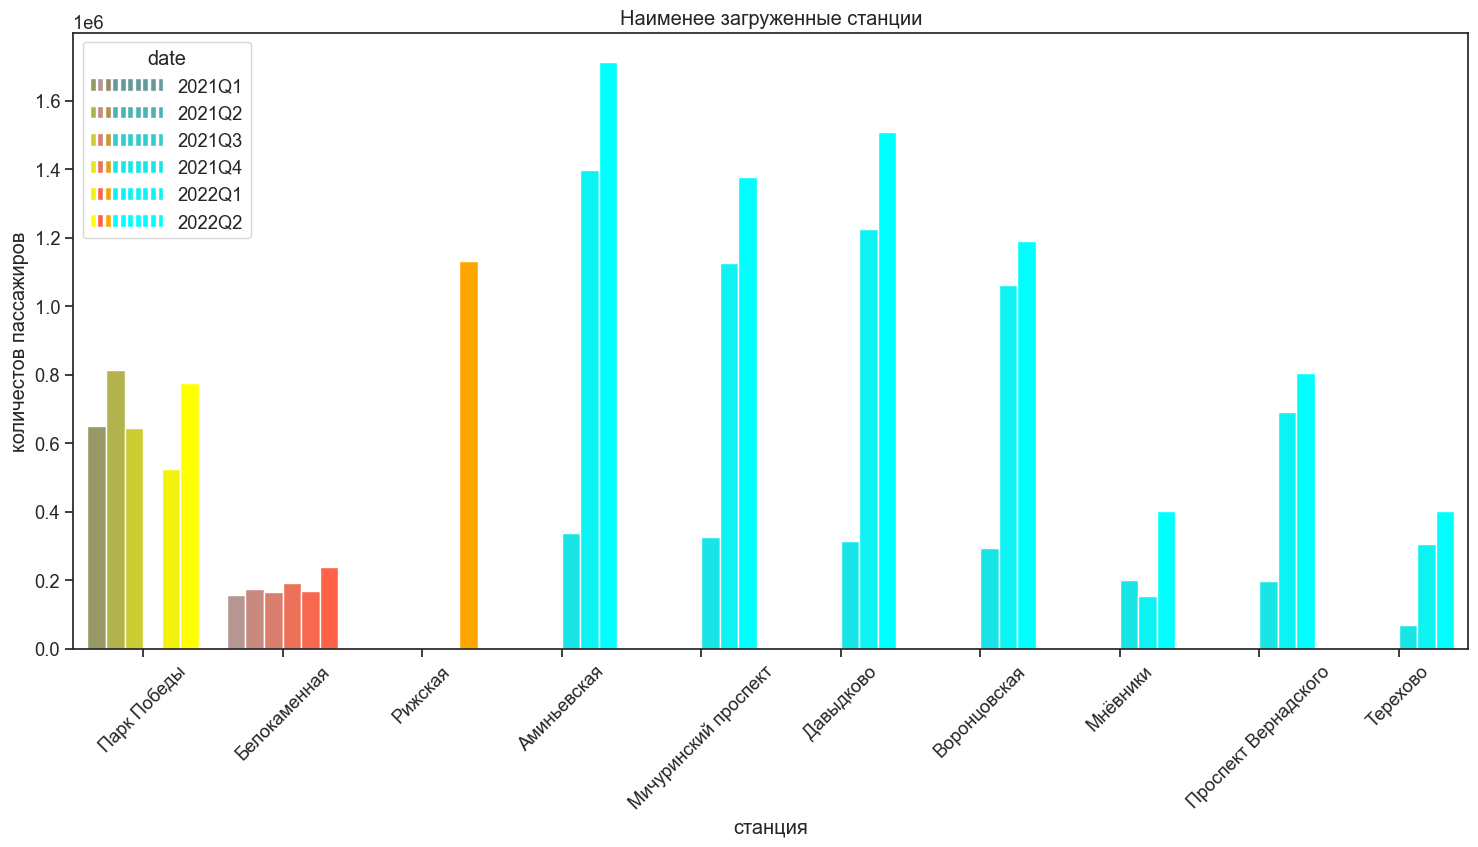

In [38]:
plt.figure(figsize=(18, 8))
colors = ['yellow', 'tomato', 'orange', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan', 'cyan',
                                      'cyan']
ax = sns.barplot(x='station',
                 y='total_pass', hue='date', data=data_station_botom)
for bar_group, desaturate_value in zip(ax.containers, [0.2, 0.4, 0.6, 0.8, 0.9, 1]):
    for bar, color in zip(bar_group,colors ):
        bar.set_facecolor(sns.desaturate(color, desaturate_value))
ax.set(title='Наименее загруженные станции',
       xlabel='станция', ylabel='количестов пассажиров')
ax.legend(handles=[tuple(bar_group) for bar_group in ax.containers],
          labels=[bar_group.get_label() for bar_group in ax.containers],
          title=ax.legend_.get_title().get_text(),
          handlelength=4, handler_map={tuple: HandlerTuple(ndivide=None, pad=0.1)})


plt.xticks(rotation=45)
plt.show()

Стабильно низкий пассажиропоток у белокаменной. Скорее всего, её построили на перспективу. Аналогичная ситуация и у Мневники. Виден рост потока у всех остальных станций БКЛ. Ну и в этот график попала Рижская, так как её закрывали, и только недавно открыли. Люди не так быстро меняют свои маршруты, поэтому поток с открытием востановится не сразу. 

Создаем таблицу для Heatmap для карты. Поэтому оставим только пассажиропоток и координаты

In [39]:
transport_heatmap = transport_data[[
    "latitude", "longitude", "total_pass"]]
transport_heatmap

latitude  longitude  total_pass
0      55.8457    37.3622     3742529
1      55.8457    37.3622     4110333
2      55.8457    37.3622     4000013
3      55.8457    37.3622     4307504
4      55.8457    37.3622     3926616
...        ...        ...         ...
1537   55.7578    37.6190           0
1538   55.7578    37.6190           0
1539   55.7512    37.6100           0
1540   55.7512    37.6100           0
1541   55.7512    37.6100           0

[1512 rows x 3 columns]

Создаем таблицу для Heatmap с временной линией для карты. Поэтому оставим пассажиропоток, координаты и временные промежутки.

In [40]:
pd.options.mode.chained_assignment = None
transport_heatmap_time = transport_data[[
    "latitude", "longitude", "total_pass", "date"]]
transport_heatmap_time['date'] = pd.PeriodIndex(transport_heatmap_time['date'], freq='Q')
transport_heatmap_time

latitude  longitude  total_pass    date
0      55.8457    37.3622     3742529  2021Q1
1      55.8457    37.3622     4110333  2021Q2
2      55.8457    37.3622     4000013  2021Q3
3      55.8457    37.3622     4307504  2021Q4
4      55.8457    37.3622     3926616  2022Q1
...        ...        ...         ...     ...
1537   55.7578    37.6190           0  2022Q1
1538   55.7578    37.6190           0  2022Q2
1539   55.7512    37.6100           0  2021Q4
1540   55.7512    37.6100           0  2022Q1
1541   55.7512    37.6100           0  2022Q2

[1512 rows x 4 columns]

Создаем временнной промежуток для  heatmap с временной шкалой

In [41]:
time_index = list(transport_heatmap_time['date'].sort_values().astype('str').unique())


In [42]:
data = []
for _, d in transport_heatmap_time.groupby('date'):
    data.append([[row['latitude'], row['longitude'], row['total_pass']] for _, row in d.iterrows()])


## Визуализация карты метро с учетом входа, выхода и суммы. 

In [43]:


m = folium.Map(location=[55.75, 37.63], tiles='openstreetmap', zoom_start=10)

shapesLayer = folium.FeatureGroup(name="Lines").add_to(m)
shapesLayerenters = folium.FeatureGroup(name="Vector Shapes enters").add_to(m)
shapesLayerexits = folium.FeatureGroup(name="Vector Shapes exits").add_to(m)
shapesLayertotal = folium.FeatureGroup(name="Vector Shapes total").add_to(m)
shapesLayehm = folium.FeatureGroup(name="Heat_map").add_to(m)

for i in range(0, len(transport_data)):
    folium.Circle(
        location=[transport_data.iloc[i]['latitude'],
                  transport_data.iloc[i]['longitude']],
        popup=transport_data.iloc[i]['total_pass'],
        tooltip=transport_data.iloc[i]['station'],
        radius=(transport_data.iloc[i]['total_pass'])/200000,
        color=transport_data.iloc[i]['line_color'],
        fill=True,
        fill_color=transport_data.iloc[i]['line_color']).add_to(shapesLayertotal)
folium.TileLayer("", name="None", attr="white").add_to(shapesLayertotal)


for i in range(0, len(transport_data)):
    folium.Circle(
        location=[transport_data.iloc[i]['latitude'],
                  transport_data.iloc[i]['longitude']],
        popup=transport_data.iloc[i]['pass_entr'],
        tooltip=transport_data.iloc[i]['station'],
        radius=(transport_data.iloc[i]['pass_entr'])/200000,
        color=transport_data.iloc[i]['line_color'],
        fill=True,
        fill_color=transport_data.iloc[i]['line_color']).add_to(shapesLayerenters)
folium.TileLayer("", name="None", attr="white").add_to(shapesLayerenters)

for i in range(0, len(transport_data)):
    folium.Circle(
        location=[transport_data.iloc[i]['latitude'],
                  transport_data.iloc[i]['longitude']],
        popup=transport_data.iloc[i]['pass_exit'],
        tooltip=transport_data.iloc[i]['station'],
        radius=(transport_data.iloc[i]['pass_exit'])/200000,
        color=transport_data.iloc[i]['line_color'],
        fill=True,
        fill_color=transport_data.iloc[i]['line_color']).add_to(shapesLayerexits)
folium.TileLayer("", name="None", attr="white").add_to(shapesLayerexits)


sort_table = transport_data.sort_values('index')

number_list = list(sort_table['line_number'].unique())

l_count = 0

for i in range(0, len(number_list)):
    folium.PolyLine(get_coordinates(number_list[l_count]),
                    color=list(get_colors(number_list[l_count])),
                    weight=4 , opacity=1).add_to(shapesLayer)
    l_count += 1


folium.TileLayer("", name="None", attr="white").add_to(m)


HeatMap(transport_heatmap, 
        min_opacity=0.4,
        blur = 18
               ).add_to(folium.FeatureGroup(name='Heat Map').add_to(shapesLayehm))


# Show the map again

m.add_child(folium.map.LayerControl(collapsed=True))

m

Как видно из карты, наибольший поток по прежнему приходится на центральные станции и Комсомольскую. Стоит отметить, что хоть и очень стараются вести многие ветки через район делового центра, то там пассажироток остается не высоким.
Так же можно отметить, что практически у всех веток "хвост" ярче, чем его продолжение. Это говорит о том, что люди из подмосковья добираются до ближайшей станции метро и продолжают свой путь.

## Карта метро загруженности с таймлайном 

In [44]:
m = folium.Map(location=[55.75, 37.63], tiles='openstreetmap', zoom_start=10)
HeatMapWithTime(data,
                index=time_index,
                auto_play=True,
                
               ).add_to(m)

m

На перспективной карте видно, что поток меняется не так значительно, как может показаться. но зато можно отметить появление станций БКЛ. 

# Вывод

Вряд ли в ближайшее время изменятся наиболее загруженные станции. Они находсятся на окраинах.  Разгрузить их могут разве что ввод других станций рядом или альтернативные способы передвижения. Возможно на это повлияют диамтеры. Но, к сожалению, данных о пассажироптоке на них не выложены в открытый доступ, поэтому нет возможности сравнить изменения.  Но зато могут поменяться наименее загруженные, так как видет рост пассажиропотока на БКЛ. В перспективе БКЛ может частично разгрузить центральные станции, куда сейчас приходятся большая часть пересадок. Но влияние будет таким же незначительным, как и ввод МЦК. Из графиков видно, что его пассажиропоток устаканился и растет приблизительно так же, как и на других ветках. Пассажиропоток подвержен сезонному влиянию, но оно не такое сильное.

Фокус властей на диаметрах должен принести результат и частично разгрузить некоторых загруженные конечные станции. 

# Итоги. 

* подготовлены данные к анализу
* полученные данные изучены и добавлены необходимые для исследования данные. 
* выявлены самые загруженные станции
* выявлены наименее загруженные станции
* выявлены самые загруженные ветки
* построена карта со всеми станциями метро с учетом пассажиропотока
* построена карта с таймлайном 
* сделаны выводы